In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as K
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-17 17:20:22.971404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading The Data

In [2]:
with h5py.File("info/data/output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("info/data/output_bg.h5", "r") as file:
    bg_data = file["events"][:]

# 'Unstructuring' Data

In [3]:
signal_data = structured_to_unstructured(signal_data)
bg_data = structured_to_unstructured(bg_data)

# Train - Validation - Test Splits

In [4]:
X = np.concatenate([signal_data, bg_data])
y = np.concatenate([np.ones(signal_data.shape[0], dtype=int), np.zeros(bg_data.shape[0], dtype=int)])

x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=0.5)

# Data Preprocessing

In [5]:
preprocessing_layer = K.layers.Normalization()
preprocessing_layer.adapt(x_train)

# Model training

In [6]:
model = K.Sequential(
    [
        preprocessing_layer,
        K.layers.Dense(50, activation="relu", name="hidden1"),
        K.layers.Dense(25, activation="relu", name="hidden2"),
        K.layers.Dense(10, activation="relu", name="hidden3"),
        K.layers.Dense(1, activation="sigmoid", name="output"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 18)               37        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 50)                950       
                                                                 
 hidden2 (Dense)             (None, 25)                1275      
                                                                 
 hidden3 (Dense)             (None, 10)                260       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 2,533
Trainable params: 2,496
Non-trainable params: 37
_____________________________________________________

In [7]:
model.compile(
    optimizer=K.optimizers.Adam(learning_rate=0.0002),
    loss=K.losses.BinaryCrossentropy(),
    metrics=[K.metrics.BinaryAccuracy()],
)

In [8]:
early_stopping_callback = K.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.002, 
    restore_best_weights=True,
    verbose=1,)

In [9]:
fit_history = model.fit(
        x_train,
        y_train,
        batch_size=100,
        epochs=100,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping_callback],
    )

print("Printing summary of the trained model:")
print(model.summary())

Epoch 1/100
5933/5933 [==============================] - 5s 689us/step - loss: 0.3922 - binary_accuracy: 0.8258 - val_loss: 0.3739 - val_binary_accuracy: 0.8343
Epoch 2/100
5933/5933 [==============================] - 4s 678us/step - loss: 0.3687 - binary_accuracy: 0.8390 - val_loss: 0.3704 - val_binary_accuracy: 0.8365
Epoch 3/100
5933/5933 [==============================] - 4s 703us/step - loss: 0.3659 - binary_accuracy: 0.8403 - val_loss: 0.3682 - val_binary_accuracy: 0.8377
Epoch 4/100
5933/5933 [==============================] - 4s 723us/step - loss: 0.3645 - binary_accuracy: 0.8410 - val_loss: 0.3674 - val_binary_accuracy: 0.8384
Epoch 5/100
5933/5933 [==============================] - 5s 773us/step - loss: 0.3635 - binary_accuracy: 0.8415 - val_loss: 0.3670 - val_binary_accuracy: 0.8391
Epoch 6/100
5933/5933 [==============================] - 4s 718us/step - loss: 0.3627 - binary_accuracy: 0.8420 - val_loss: 0.3667 - val_binary_accuracy: 0.8388
Epoch 7/100
5933/5933 [===========

In [10]:
save_name = "my_model"
print(f'Storing model with name "{save_name}" now. You can convert '
        'this to ONNX format with the "tf2onnx" command-line utility.')
model.save(save_name)

Storing model with name "my_model" now. You can convert this to ONNX format with the "tf2onnx" command-line utility.


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


The following code produces a plot of the loss evolution for training and validation:

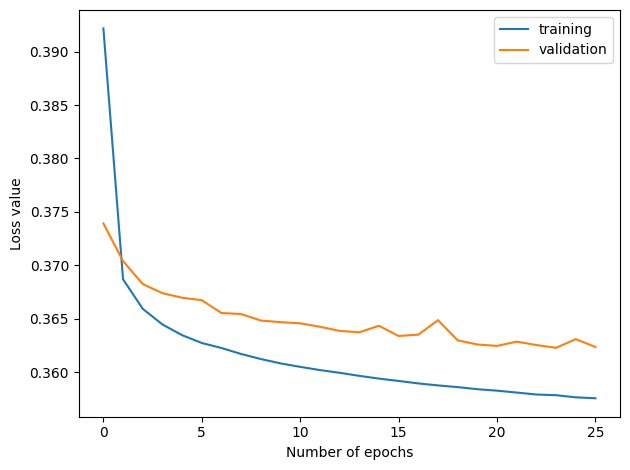

In [11]:
plt.plot(fit_history.history["loss"], label="training")
plt.plot(fit_history.history["val_loss"], label="validation")
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.legend()
plt.tight_layout()
plt.savefig("base_loss.pdf")
plt.show()

The following code produces a plot of the accuracy evolution per epoch for training and validation:

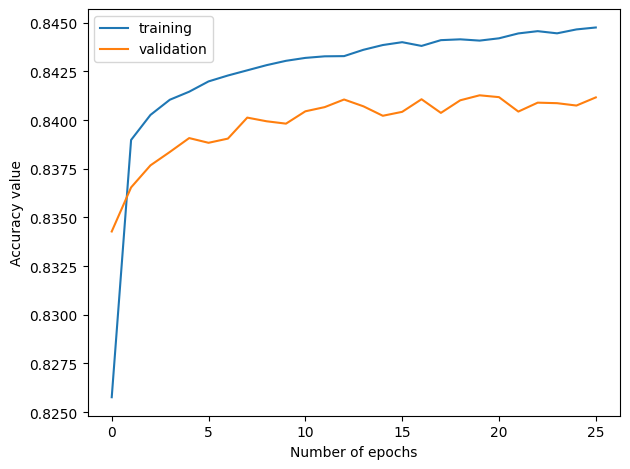

In [12]:
plt.figure()
plt.plot(fit_history.history["binary_accuracy"], label="training")
plt.plot(fit_history.history["val_binary_accuracy"], label="validation")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy value")
plt.legend()
plt.tight_layout()
plt.savefig("base_accuracy.pdf")

The following code plots the distribution of the neural-network output node for both training and test data to check for possible differences between the two. The datasets are sliced according to their truth labels (i.e. the two classes).

5810/5810 [==============================] - 2s 412us/step


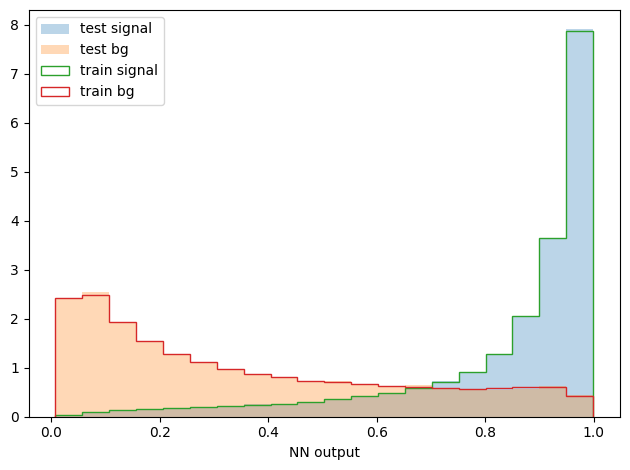

Created plots of loss, accuracy, and NN output.


In [13]:
 """Creates a plot of the NN output for training and test data.

    The function slices both training and test data according to the truth
    labels, so that the displayed spectra can be split into "background" and
    "signal" events (i.e. the two classes the model was trained on).

    """

_, bins, _ = plt.hist(model.predict(x_test[y_test.astype(bool)]), bins=20, alpha=0.3, density=True, label="test signal")
plt.hist(model.predict(x_test[~y_test.astype(bool)]), bins=bins, alpha=0.3, density=True, label="test bg")
plt.hist(model.predict(x_train[y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train signal")
plt.hist(model.predict(x_train[~y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train bg")
plt.xlabel("NN output")
plt.legend()
plt.tight_layout()
plt.savefig("base_NNout.pdf")
plt.show()
print("Created plots of loss, accuracy, and NN output.")